# Poisson Inverting ConvolutionS (PICS)
Uses the Tensoflow machine learning library to train the Poisson Inverting ConvolutionS (PICS) to reconstruct compressed ***MNIST*** images with imposed Poisson noise.

**Author:** Fabian Santiago  
**Update:** August 21, 2024

**Implementation:** PICS architecture discussed in:
**[IEEE publication](https://ieeexplore.ieee.org/abstract/document/8682767)**

## Import Modules and Libraries

In [1]:
# Import necessary modules and libraries 
from __future__ import division, print_function, absolute_import
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.util.shape import view_as_windows

2024-08-21 17:31:41.785707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set Values: Seed, Compression, and Output Dimension

In [2]:
# Set the seed for TensorFlow and Keras
tf.random.set_seed(101)

# Dimension of the compressed/noisy images (width=height)  
# cmp_dim = 4:(for 4x4), 7:(7x7), 14:(14x14), or 28:(28x284)
cmp_dim = 7

# Dimension of output, original are 28 x 28
out_dim  = 28 

## Helper Function Definitions

In [3]:
# Define sliding window compression
def median_downsampling(in_image, cmp_dim):
    if cmp_dim < 15:
        # Compression dimension to window size
        window_size = 28//cmp_dim
        # Create sliding windows
        windows = view_as_windows(in_image, (window_size, window_size), step=window_size)
        # Calculate the median over each window
        return np.median(windows, axis=(2, 3))
    else:
        return in_image

# Define compression of entries in an array
def down_sample_list(in_array,cmp_dim):
    out_array = np.empty((len(in_array), cmp_dim, cmp_dim))
    
    # Iterate over array
    for idx, image in enumerate(in_array):
        out_array[idx] = median_downsampling(image,cmp_dim)
        
    # Return array containing compressed entries 
    return out_array 

# Split dataset into two
def split_dataset_rnd(in_images):

    # Total number of images
    num_images = in_images.shape[0]
    
    # Random permutation of indices
    shuffled_indices = np.random.permutation(num_images)
    
    # Calculate the split index
    split_index = num_images // 2
    
    # Split the shuffled indices
    idx1 = shuffled_indices[:split_index]
    idx2 = shuffled_indices[split_index:]
    
    # Use the indices to create two random datasets
    dat1 = in_images[idx1]
    dat2 = in_images[idx2]
    
    return dat1, dat2

# Create compressed noisy data
def create_training_test_data(clean_train, clean_test, cmp_dim, out_dim):
    
    # Step 0: Create Training and Validation Sets
    clean_test, clean_valid = split_dataset_rnd(clean_test)
    
    # Step 1: Compress images using median in sliding window
    cmp_train = down_sample_list(clean_train, cmp_dim)
    cmp_test  = down_sample_list(clean_test, cmp_dim)
    cmp_valid  = down_sample_list(clean_valid, cmp_dim)

    # Step 2: Add Poisson noise to compressed images
    noisy_train_ = np.random.poisson(lam=cmp_train)
    noisy_test_  = np.random.poisson(lam=cmp_test)
    noisy_valid_ = np.random.poisson(lam=cmp_valid)
    
    noisy_train  = np.clip(noisy_train_,0,255)
    noisy_test   = np.clip(noisy_test_,0,255)
    noisy_valid  = np.clip(noisy_valid_,0,255)
    
    # Step 3: Reshape Input Arrays and scale from [0, 255] to [0,1]
    noisy_train = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_train/255])
    noisy_test  = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_test/255])
    noisy_valid = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_valid/255])
    
    # Step 4: Reshape Expected Ouput Arraus and scale from [0, 255] to [0,1]
    clean_train = np.array([matrix.reshape(out_dim**2,) for matrix in clean_train/255])
    clean_test  = np.array([matrix.reshape(out_dim**2,) for matrix in clean_test/255])
    clean_valid = np.array([matrix.reshape(out_dim**2,) for matrix in clean_valid/255])
    
    # Step 5: Return training data
    return [clean_train, clean_test, clean_valid, noisy_train, noisy_test, noisy_valid]

# Poisson Inverting ConvolutionS (PICS) Builder
def build_PICS(in_dim=14, out_dim=28, flt_dim=2):
    flt2_dpth = int((in_dim + 0.5) / 2)
    
    model = models.Sequential()
    
    # Add the Input layer
    model.add(layers.InputLayer(shape=(in_dim**2,)))
    
    # Fully connected layer to reshape input to output shape
    # output shape: (28 * 28,)
    model.add(layers.Dense(out_dim * out_dim))
    
    # Reshape the input to use as input to Conv2D
    # output shape: (28, 28, 1)
    model.add(layers.Reshape((out_dim, out_dim, 1)))
    
    # First convolutional layer
    # output shape: (28, 28, 14)
    model.add(layers.Conv2D(in_dim, (flt_dim, flt_dim), activation='relu', padding='same'))
    
    # Second convolutional layer
    # output shape: (28, 28, 7)
    model.add(layers.Conv2D(flt2_dpth, (flt_dim, flt_dim), activation='relu', padding='same'))
    
    # Third convolutional layer
    # output shape: (28, 28, 1)
    model.add(layers.Conv2D(1, (flt_dim, flt_dim), activation='relu', padding='same'))
    
    # Flatten output to 1D
    # output shape: (28 * 28,)
    model.add(layers.Flatten())
    
    return model

## Load/Create Training Data
Load traning data or load MNIST data and create training data if it has not already been created

In [4]:
directory = 'training_data'

# If the directory does not exist, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Load the MNIST Dataset
file = f'mnist_training_data_cmp' # Do not modify

# If the training data does not exist, create it
if not os.path.exists(f'{directory}/{file}.h5'):
    # Load MNIST
    (clean_train, _), (clean_test, _) = tf.keras.datasets.mnist.load_data()
    
    # Create compressed/noisy data, test set, and validation set
    train_data = create_training_test_data(clean_train, clean_test, cmp_dim, out_dim)
    
    # MNIST data
    clean_train = train_data[0]
    clean_test  = train_data[1]
    clean_valid = train_data[2]
    
    # Compressed noisy signals
    noisy_train = train_data[3]
    noisy_test  = train_data[4]
    noisy_valid = train_data[5]
    
    # Save with compression
    with h5py.File(f'{directory}/{file}_{cmp_dim}x{cmp_dim}.h5', 'w') as f:
        # Save original images
        f.create_dataset('clean_train', data=clean_train, compression='gzip')
        f.create_dataset('clean_test', data=clean_test, compression='gzip')
        f.create_dataset('clean_valid', data=clean_valid, compression='gzip')
        
        # Save compressed noisy images
        f.create_dataset('noisy_train', data=noisy_train, compression='gzip')
        f.create_dataset('noisy_test', data=noisy_test, compression='gzip')
        f.create_dataset('noisy_valid', data=noisy_valid, compression='gzip')
        
else: # If data exists, load it
    with h5py.File(f'{directory}/{file}_{cmp_dim}x{cmp_dim}.h5', 'r') as dat_file:

        # Load original MNIST images
        clean_train = dat_file['clean_train'][:]
        clean_test  = dat_file['clean_test'][:]
        clean_valid = dat_file['clean_valid'][:]

        # Load compressed noisy images
        noisy_train = dat_file['noisy_train'][:]
        noisy_test  = dat_file['noisy_test'][:]
        noisy_valid = dat_file['noisy_valid'][:]

## Display Training Dataset Examples

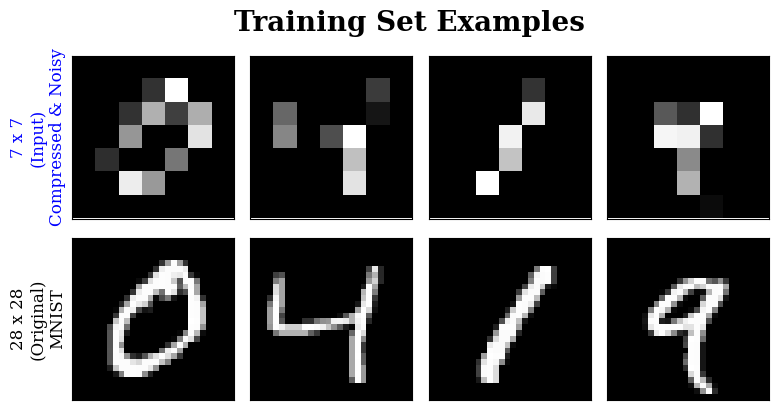

In [5]:
# Create a 2 by 4 subplot handle
fig, axes = plt.subplots(2, 4, figsize=(9, 4.5))
axes      = axes.flatten()

# Add title
fig.suptitle('Training Set Examples', fontsize=20, fontweight='bold', fontfamily='serif')

# Shift window through training dataset 
sft_idx = 1

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
#     axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot original
    axes[idx+4].imshow(clean_train[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
# Set ylables 
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel('28 x 28\n(Original)\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Display the figure
plt.show()

## Compile & Train Model

In [6]:
# Create & Compile the PICS model
PICS = build_PICS(in_dim=cmp_dim, out_dim=out_dim, flt_dim=2)

# Create an RMSProp optimizer with a specific learning rate
RMSp = tf.keras.optimizers.RMSprop(learning_rate=0.05)

# Compile the model
PICS.compile(optimizer=RMSp, loss='mean_squared_error')

# Train model saving fitting history
fit_history = PICS.fit(noisy_train, clean_train, epochs=40, batch_size=250, validation_data=(noisy_test, clean_test))

Epoch 1/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0598 - val_loss: 0.0389
Epoch 2/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0367 - val_loss: 0.0356
Epoch 3/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0348 - val_loss: 0.0334
Epoch 4/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0335 - val_loss: 0.0334
Epoch 5/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0329 - val_loss: 0.0329
Epoch 6/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0326 - val_loss: 0.0330
Epoch 7/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0323 - val_loss: 0.0325
Epoch 8/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0321 - val_loss: 0.0323
Epoch 9/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0320 - val_loss: 0.0323
Epoch 10/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0318 - val_loss: 0.0327
Epoch 11/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0317 - val_loss: 0.0328
Epoch 12/40
240/240 ━━━━━━━━━━

In [7]:
PICS.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │        39,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 7)      │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 3)      │            87 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,672 (307.32 KB)

 Trainable params: 39,335 (153.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,337 (153.66 KB)

## Apply PICS to Training Set and Display Example Output

In [8]:
pred_train_out = PICS.predict(noisy_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


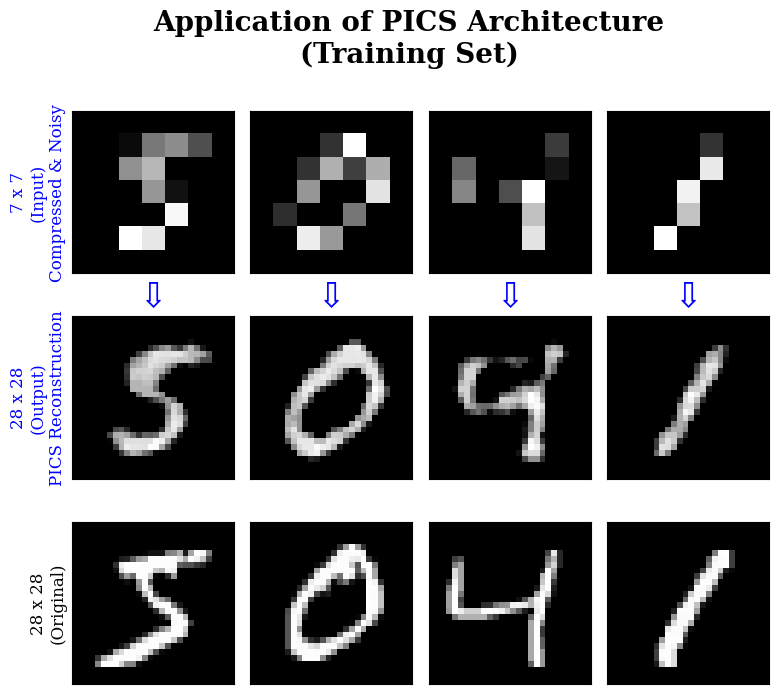

In [9]:
# Print examples: training set
################################

# Create a 3 by 4 subplot handle
fig, axes = plt.subplots(3, 4, figsize=(9, 8))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of PICS Architecture\n(Training Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift window through training dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot decompressed with PICS
    axes[idx+4].imshow(pred_train_out[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+8].imshow(clean_train[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
# Set ylables 
# axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Pre-Input)\nCompressed',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel(f'{out_dim} x {out_dim}\n(Output)\nPICS Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[8].set_ylabel(f'{out_dim} x {out_dim}\n(Original)',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.0)

# Display the figure
plt.show()

## Apply PICS to Validation Set and Display Output

In [10]:
# Apply PICS to all validation inputs
pred_valid_out = PICS.predict(noisy_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


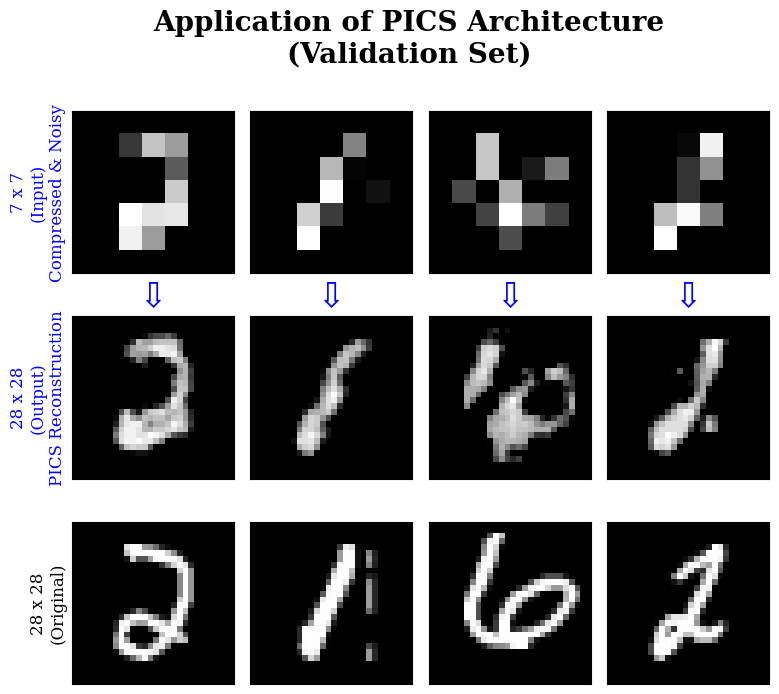

In [11]:
# Print examples: validation set
################################

# Create a 3 by 4 subplot handle
fig, axes = plt.subplots(3, 4, figsize=(9, 8))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of PICS Architecture\n(Validation Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift window through validation dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_valid[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot decompressed with PICS
    axes[idx+4].imshow(pred_valid_out[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+8].imshow(clean_valid[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
# Set ylables 
# axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Pre-Input)\nCompressed',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel(f'{out_dim} x {out_dim}\n(Output)\nPICS Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[8].set_ylabel(f'{out_dim} x {out_dim}\n(Original)',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0)

# Display the figure
plt.show()